In [86]:
import os
import keras_cv
import tensorflow as tf
from tensorflow import keras



In [87]:
SPLIT_RATIO = 0.1
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 5
GLOBAL_CLIPNORM = 10.0

In [88]:
class_ids = [
    "belcebu",
    "mazapan",
    "nina",
    "uxia"
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

bounding_box_format = "rel_xywh"

path_dataset = "updated-images-and-labels"
path_weights = "best.h5"

annotations = sorted(
    [
        os.path.join(path_dataset, file_name)
        for file_name in os.listdir(path_dataset)
        if file_name.endswith(".txt")
    ]
)

images = sorted(
    [
        os.path.join(path_dataset, file_name)
        for file_name in os.listdir(path_dataset)
        if file_name.endswith(".jpg")
    ]
)

assert len(images) == len(annotations)

In [89]:
classes = []
boxes = []
for annotation_path in annotations:
	classes_for_img = []
	boxes_for_img = []
	with open(annotation_path) as annotation_file:
		for line in annotation_file.readlines():
			classes_for_img.append(int(line.split(' ')[0]))
			boxes_for_img.append([float(n) for n in line.strip().split(' ')[1:]])
	classes.append(classes_for_img)
	boxes.append(boxes_for_img)
boxes = tf.ragged.constant(boxes)
classes = tf.ragged.constant(classes)
images = tf.ragged.constant(images)

data = tf.data.Dataset.from_tensor_slices((images, classes, boxes))

num_val = int(len(images) * SPLIT_RATIO)
val_data = data.take(num_val)
train_data = data.skip(num_val)


In [90]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3, ratio=1)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

def visualize_dataset(inputs, value_range, rows, cols):
    inputs = next(iter(inputs.take(1)))
    
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
	

    keras_cv.visualization.plot_bounding_box_gallery(
        images=images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_pred=bounding_boxes,
        scale=3,
        font_scale=1.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format=bounding_box_format
)

In [91]:
train_ds = (train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
                .shuffle(BATCH_SIZE * 4)
               .ragged_batch(BATCH_SIZE, drop_remainder=True)
.map(inference_resizing, num_parallel_calls=tf.data.AUTOTUNE))

val_ds = (val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
                .shuffle(BATCH_SIZE * 4)
               .ragged_batch(BATCH_SIZE, drop_remainder=True)
.map(inference_resizing, num_parallel_calls=tf.data.AUTOTUNE))


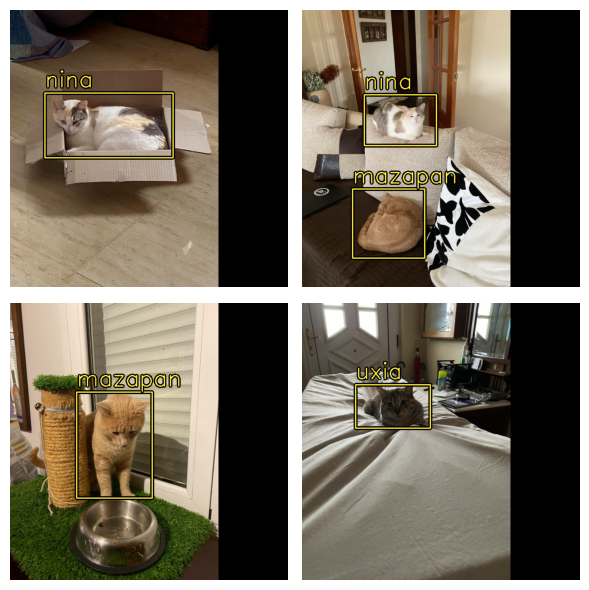

In [92]:
visualize_dataset(inputs=train_ds, value_range=(0,255), rows=2,cols=2)

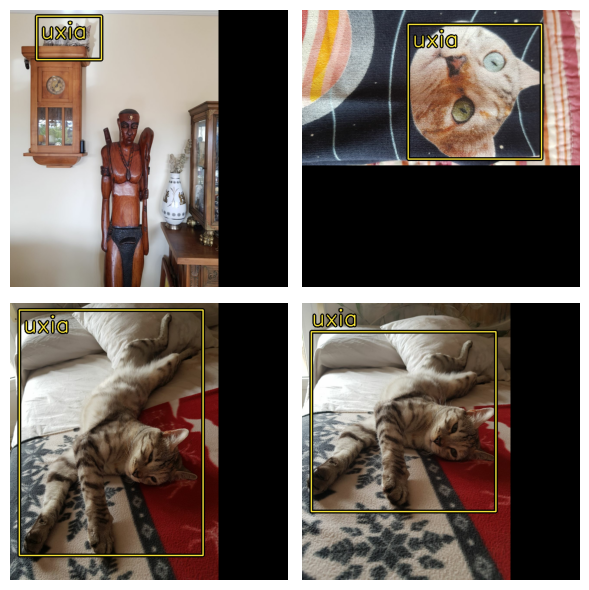

In [93]:
visualize_dataset(inputs=val_ds, value_range=(0,255), rows=2,cols=2)

In [94]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [95]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco"  # We will use yolov8 small backbone with coco weights
)

yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format=bounding_box_format,
    backbone=backbone,
    fpn_depth=1,
)

optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

In [96]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format=bounding_box_format,
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs

In [97]:
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, path_weights)],
)

Epoch 1/3
 19/197 [=>............................] - ETA: 15:26 - loss: 400.1572 - box_loss: 2.5239 - class_loss: 397.6332

KeyboardInterrupt: 